<a href="https://colab.research.google.com/github/lisosoma/ML-for-demographic-inference/blob/main/ML_DI_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install libraries

In [ ]:
!pip install dadi

### DE part

Generate sample data using dadi 

#### 2_DivMig_5_Sim model

In [3]:
import scipy.stats as sts
import pylab
import dadi
import numpy as np

In [4]:
# Code from the repository of Ekaterina Noskova

def model_func(params, ns, pts):
    """
    Simple two populations model. Ancestral population of constant size splits
    into two subpopulations of constant size with asymetrical migrations.
    :param nu1: Size of subpopulation 1 after split.
    :param nu2: Size of subpopulation 2 after split.
    :param m12: Migration rate from subpopulation 2 to subpopulation 1.
    :param m21: Migration rate from subpopulation 1 to subpopulation 2.
    :param T: Time of split.
    """

    nu1, nu2, m12, m21, T = params

    xx = dadi.Numerics.default_grid(pts)
    phi = dadi.PhiManip.phi_1D(xx)

    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    phi = dadi.Integration.two_pops(phi, xx, T, nu1=nu1, nu2=nu2, m12=m12, m21=m21)

    fs = dadi.Spectrum.from_phi(phi, ns, [xx, xx])
    return fs

In [5]:
n_pop = 2
pop_labels = ["Pop 1", "Pop 2"]

par_labels = ['nu1', 'nu2', 'm12', 'm21', 'T']

lower_bound = [1e-2, 1e-2, 0, 0, 1e-15]
upper_bound = [100, 100, 10, 10, 5]

mu = 2.5e-8  # mutation rate
L = 20000000  # effective length of sequence
Nanc = 10000
theta = 4 * mu * L * Nanc  # mutation flux

ns_per_pop = 20
ns = [ns_per_pop for _ in range(n_pop)]
pts_l = 20

#### Creating file with sample data

In [6]:
names = np.linspace(1, (pts_l + 1) ** 2, (pts_l + 1) ** 2, endpoint = True, dtype = int)
a = " ".join(names.astype(str))
a += '\n'

In [7]:
with open('/content/data.txt', 'w') as f:
    f.seek(0, 2) 
    f.write(a)

First sample

In [ ]:
y_cur1 = np.concatenate([[sts.uniform.rvs(loc = lower_bound[0], scale = upper_bound[0] + lower_bound[0], size = 5000).T],
                   [sts.uniform.rvs(loc = lower_bound[1], scale = upper_bound[1] + lower_bound[1], size = 5000).T],
                   [sts.uniform.rvs(loc = lower_bound[2], scale = upper_bound[2] + lower_bound[2], size = 5000).T],
                   [sts.uniform.rvs(loc = lower_bound[3], scale = upper_bound[3] + lower_bound[3], size = 5000).T],
                   [sts.uniform.rvs(loc = 0.001, scale = 0.101, size = 5000).T]]).T

Second sample

In [ ]:
k = 1000
y1 = np.array([[0.1, 5, 2.5, 0.05]]* k)
y1 = np.concatenate([[np.linspace(lower_bound[0], upper_bound[0], k, endpoint = True)], y1.T]).T
y2 = np.array([[5, 2.5, 0.05]]*k)
y2 = np.concatenate([[np.ones(k)], [np.linspace(lower_bound[1], upper_bound[1], k, endpoint = True)], y2.T]).T
y3 = np.concatenate([np.array([[1, 0.1]]* k).T, [np.linspace(lower_bound[2], upper_bound[2], k, endpoint = True)], np.array([[2.5, 0.05]]* k).T]).T
y4 = np.array([[1, 0.1, 5]]*k)
y4 = np.concatenate([y4.T, [np.linspace(lower_bound[3], upper_bound[3], k, endpoint = True)], np.array([[0.05]] * k).T]).T
y5 = np.array([[1, 0.1, 5, 2.5]]* k)
y5 = np.concatenate([y5.T, [np.linspace(lower_bound[4], upper_bound[4], k, endpoint = True)]]).T
y_cur2 = np.concatenate([y1, y2, y3, y4, y5])

In [ ]:
np.savetxt(r'labels1.txt', pd.DataFrame(y_cur1))

In [ ]:
np.savetxt(r'labels2.txt', pd.DataFrame(y_cur2))

In [ ]:
for i, u in tqdm(enumerate(y_cur1)):
    popt = u
    func_ex = dadi.Numerics.make_extrap_log_func(model_func)
    model = func_ex(popt, ns, pts_l)
    data = model * theta

    data.to_file(f'/content/fs_data.txt')
    with open('/content/fs_data.txt', 'r') as f:
        for i in range(1):
            f.readline()
        x = f.readline()
        with open('/content/data1.txt', 'r+') as f:
            f.seek(0, 2) 
            f.write(x)

5000it [02:59, 27.88it/s]


### ML part

#### Import tools

In [9]:
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain

from sklearn.model_selection import train_test_split as tr
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, cross_val_score, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pdf import PdfPages

from scipy.optimize import root
from scipy.stats import randint, uniform
from math import sqrt, exp, sin

import os
from tqdm import tqdm
import pickle
import random

#### Create data

- Save data to `DataFrame`

In [ ]:
X = pd.read_table('/content/current_file.txt',sep='\s+', engine='python')

In [ ]:
y = np.linspace(0, 10, 10000, endpoint = True)

- Create train and test samples

In [ ]:
X_train, X_test, y_train, y_test = tr(X, y, train_size = 0.7, random_state=500, shuffle = True)

- For multioutput regression

In [ ]:
X_cur1 = pd.read_table('/content/drive/MyDrive/ML_DI/data1.txt',sep='\s+', engine='python').to_numpy()
y_cur1 = pd.read_table('/content/drive/MyDrive/ML_DI/labels1.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()

In [ ]:
X_cur2 = pd.read_table('/content/drive/MyDrive/ML_DI/data2.txt',sep='\s+', engine='python').to_numpy()
y_cur2 = pd.read_table('/content/drive/MyDrive/ML_DI/labels2.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()

In [ ]:
X_train1, X_test1, y_train1, y_test1 = tr(X_cur1, y_cur1, train_size = 0.5, random_state=500, shuffle = True)
X_train2, X_test2, y_train2, y_test2 = tr(X_cur2, y_cur2, train_size = 0.5, random_state=500, shuffle = True)

In [ ]:
np.savetxt(r'X_train1.txt', pd.DataFrame(X_train1))
np.savetxt(r'X_test1.txt', pd.DataFrame(X_test1))
np.savetxt(r'y_train1.txt', pd.DataFrame(y_train1))
np.savetxt(r'y_test1.txt', pd.DataFrame(y_test1))
np.savetxt(r'X_train2.txt', pd.DataFrame(X_train2))
np.savetxt(r'X_test2.txt', pd.DataFrame(X_test2))
np.savetxt(r'y_train2.txt', pd.DataFrame(y_train2))
np.savetxt(r'y_test2.txt', pd.DataFrame(y_test2))

We load previously created datasets, divided into test and training samples

In [10]:
y_train1 = pd.read_table('/content/drive/MyDrive/ML_DI/y_train1.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()
y_train2 = pd.read_table('/content/drive/MyDrive/ML_DI/y_train2.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()
y_test1 = pd.read_table('/content/drive/MyDrive/ML_DI/y_test1.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()
y_test2 = pd.read_table('/content/drive/MyDrive/ML_DI/y_test2.txt',sep='\s+', engine='python', names = [0, 1, 2, 3, 4]).to_numpy()
X_train1 = pd.read_table('/content/drive/MyDrive/ML_DI/X_train1.txt',sep='\s+', engine='python', names = names).to_numpy()
X_train2 = pd.read_table('/content/drive/MyDrive/ML_DI/X_train2.txt',sep='\s+', engine='python', names = names).to_numpy()
X_test1 = pd.read_table('/content/drive/MyDrive/ML_DI/X_test1.txt',sep='\s+', engine='python', names = names).to_numpy()
X_test2 = pd.read_table('/content/drive/MyDrive/ML_DI/X_test2.txt',sep='\s+', engine='python', names = names).to_numpy()

### Random Forest

#### Train model

In [ ]:
rfr = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=50)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=50, random_state=0)

#### Test model

In [ ]:
y_pred = rfr.predict(X_test)
print(f'For Random Forest with max_depth = {rfr.max_depth} and n_estimators = {rfr.n_estimators}:')
print(f'R2 score is equal to {r2_score(y_test, y_pred)}')
print(f'MSE score is equal to {mean_squared_error(y_test, y_pred)}')
print(f'Variance of errors is equal to {mean_squared_error(y_test, y_pred) / 3000}')
#mean_pinball_loss(y_test, y_pred)

For Random Forest with max_depth = 8 and n_estimators = 50:
R2 score is equal to 0.9999990977370584
MSE score is equal to 7.468155350707657e-06
Variance of errors is equal to 2.4893851169025523e-09


#### Choose best parameters

For choosing best parameters we used RandomizedSearchCV

In [ ]:
distributions = dict(max_depth = randint(5, 10),
                     n_estimators = randint(low=10, high=100))

grid_search = RandomizedSearchCV(rfr, param_distributions = distributions, scoring='r2')

print('\n Start Grid Search')
grid_search.fit(X, y)


 Start Grid Search


RandomizedSearchCV(estimator=RandomForestRegressor(max_depth=8, n_estimators=50,
                                                   random_state=0),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbdabbb7c50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbda129a350>},
                   scoring='r2')

In [ ]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([52.68689861, 46.16657119, 28.03199906, 38.50385628, 42.08063216,
        7.70518565, 34.65662947, 62.45977182, 44.060425  , 47.7232728 ]), 'std_fit_time': array([0.44404409, 0.53290464, 0.23685854, 0.46930044, 0.21322383,
       0.05660717, 0.63547442, 0.46048697, 0.61156525, 0.31785638]), 'mean_score_time': array([0.03470478, 0.02649779, 0.01870799, 0.02349873, 0.02383065,
       0.01054263, 0.02358041, 0.03441739, 0.02522588, 0.02823648]), 'std_score_time': array([0.00588109, 0.00388215, 0.00068244, 0.00288311, 0.00061708,
       0.00060239, 0.00089407, 0.00060257, 0.00111534, 0.0031924 ]), 'param_max_depth': masked_array(data=[8, 5, 5, 5, 5, 5, 8, 7, 6, 6],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[76, 88, 54, 74, 83, 15, 51, 98, 76, 84],
             mask=[False, False, False, False, Fal

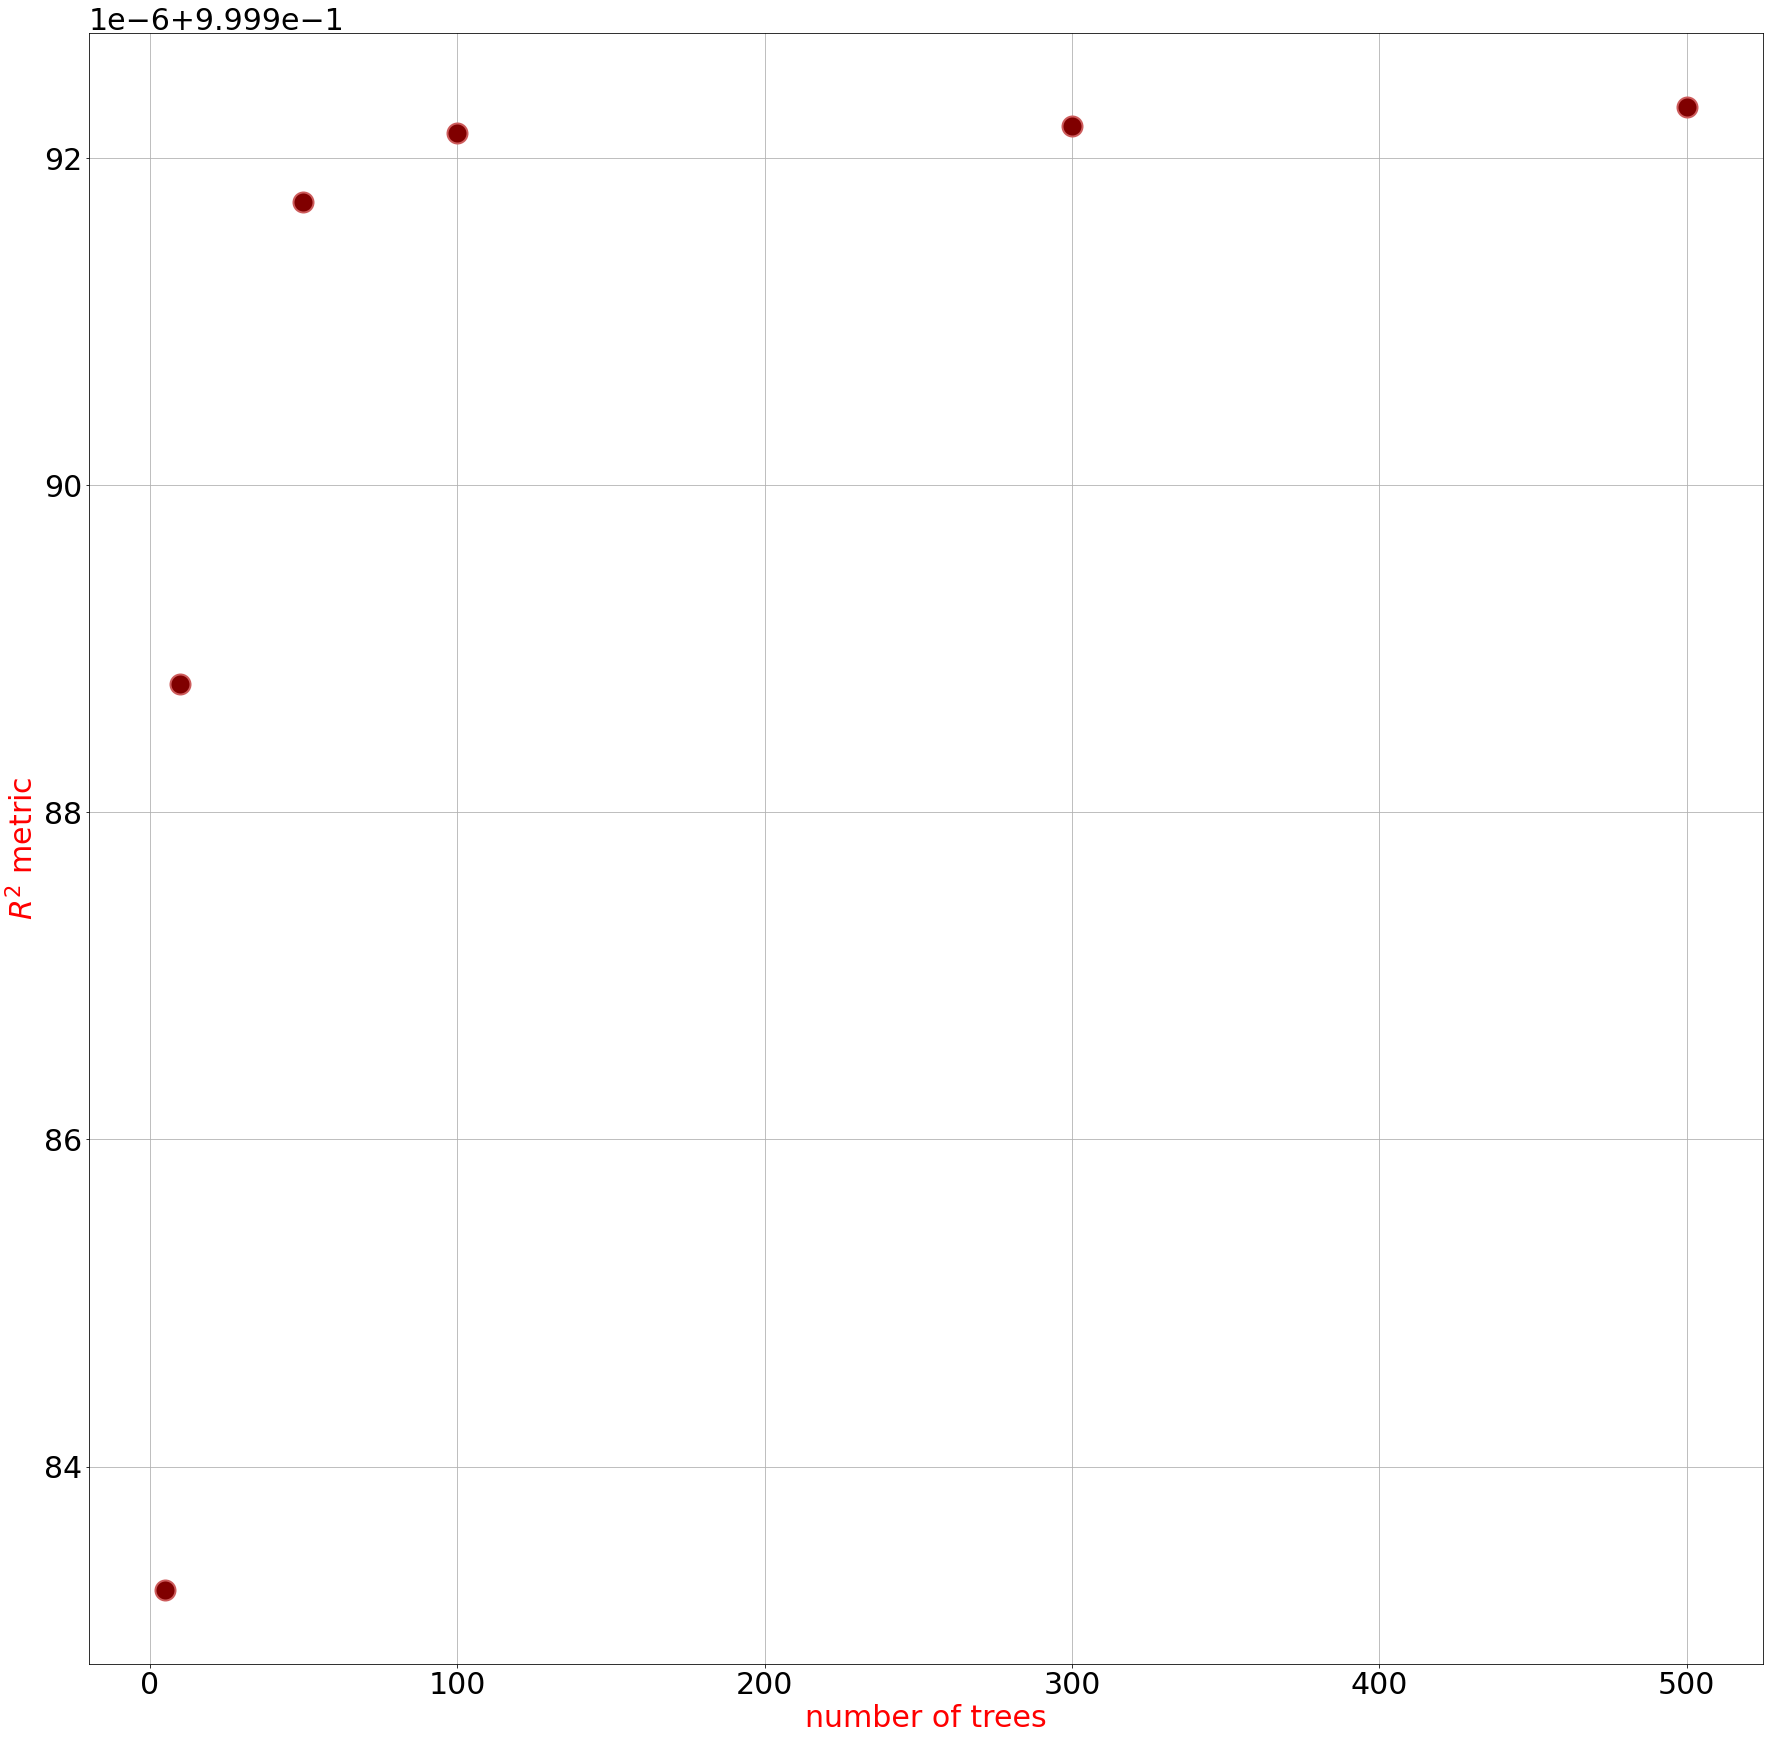

In [ ]:
def graphic(x, y, s):
    fig = plt.figure(figsize=(30, 30))
    
    plt.xlabel('number of trees', fontsize=30, color='red')
    plt.ylabel(fr'{s}', fontsize=30, color='red')
    plt.rcParams.update({'font.size': 30})
    plt.plot(x, y, color='indianred', linewidth = 0, marker = 'o', markersize = 20, markerfacecolor = 'maroon',
            markeredgecolor = 'indianred', markeredgewidth = 2)
    plt.grid(True)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.family'] = 'Calibri'
    with PdfPages(f'{s}.pdf') as pdf:
        pdf.savefig()

graphic(K, r2, s = '$R^2$ metric')

In [ ]:
rfr = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [ ]:
y_pred = rfr.predict(X_test)
print(f'For Random Forest with max_depth = {rfr.max_depth} and n_estimators = {rfr.n_estimators}:')
print(f'R2 score is equal to {r2_score(y_test, y_pred)}')
print(f'MSE score is equal to {mean_squared_error(y_test, y_pred)}')
print(f'Variance of errors is equal to {mean_squared_error(y_test, y_pred) / 3000}')

For Random Forest with max_depth = 8 and n_estimators = 76:
R2 score is equal to 0.9999991786601288
MSE score is equal to 6.7983438878673756e-06
Variance of errors is equal to 2.266114629289125e-09


#### Check errors of predicts

In [ ]:
ny = np.linspace(1, 300, 300, endpoint = True, dtype=int)

In [ ]:
def graphic_y(x, yt, yp, n):
    fig = plt.figure(figsize=(30, 15))
    
    plt.xlabel('point', fontsize=30, color='green')
    plt.ylabel(fr'parameter', fontsize=30, color='green')
    plt.rcParams.update({'font.size': 30})
    plt.plot(x, yt, color='red', linewidth = 1, marker = 'o', markersize = 15, markerfacecolor = 'maroon',
            markeredgecolor = 'indianred', markeredgewidth = 2, label = 'true', alpha = 0.3)
    plt.plot(x, yp, color='red', linewidth = 1, marker = 'o', markersize = 15, markerfacecolor = 'plum',
            markeredgecolor = 'indigo', markeredgewidth = 2, label = 'predict')
    plt.grid(True)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.family'] = 'Calibri'
    with PdfPages(f'сравнение{n}.pdf') as pdf:
        pdf.savefig()
    plt.legend()

#graphic_y(ny[:50], y_test[:50], y_pred[:50], 50)

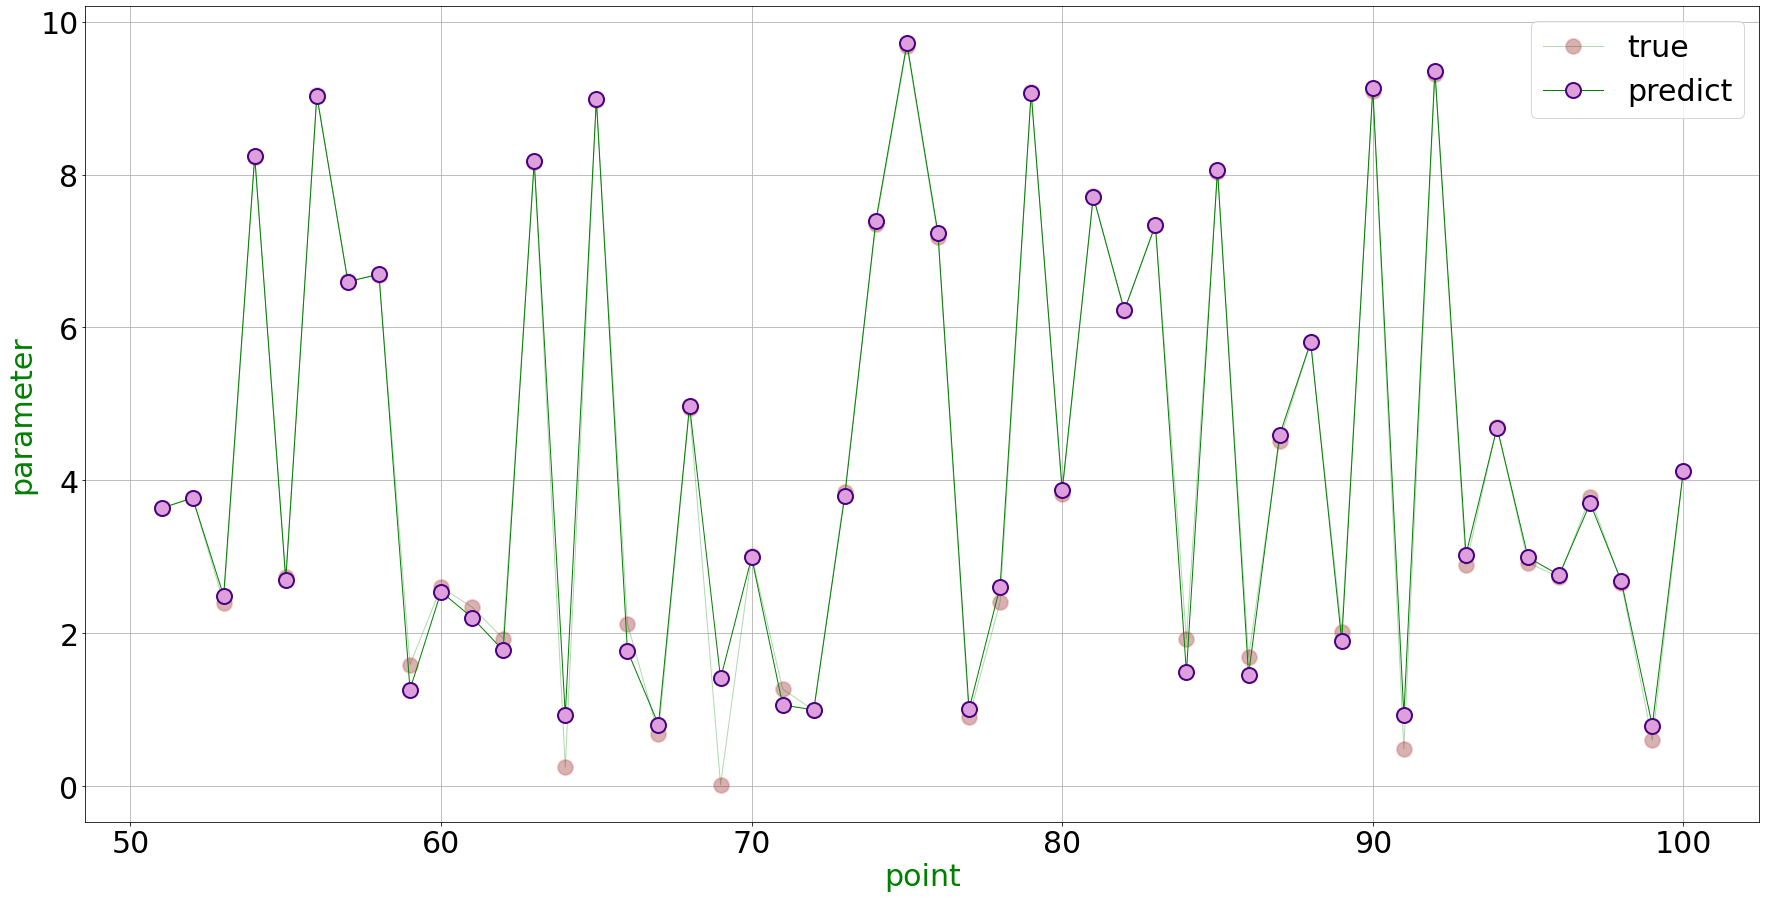

In [ ]:
graphic_y(ny[50:100], y_test[50:100], y_pred[50:100], 100)

### Multi-Output models

#### Predict four demographic history parameters: independent parameter prediction

In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
wrapper = MultiOutputRegressor(model)
#wrapper.fit(X_cur2, y_cur2)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(wrapper, X_cur2, y_cur2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
n_scores = np.absolute(n_scores)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 0.012 (0.011)


In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
#wrapper1 = MultiOutputRegressor(model)
#wrapper1.fit(X_train1, y_train1)

In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
wrapper2 = MultiOutputRegressor(model)
wrapper2.fit(X_train2, y_train2)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=8,
                                                     n_estimators=76,
                                                     random_state=0))

 - Prediction

In [ ]:
y_pred1 = wrapper1.predict(X_test1)

In [ ]:
y_pred2 = wrapper2.predict(X_test2)

- Let's check metrics for any predicted parameters

In [ ]:
parameters = ['Size of subpopulation 1 after split',
              'Size of subpopulation 2 after split',
              'Migration rate from subpopulation 2 to subpopulation 1',
              'Migration rate from subpopulation 1 to subpopulation 2', 
              'Time of split']

In [ ]:
print(f'Random Forest with max_depth = {model.max_depth} and n_estimators = {model.n_estimators}\n')
for i in range(5):
    print(f'For {parameters[i]}\n')
    print(f'R2 score is equal to {r2_score(y_test1.T[i], y_pred1.T[i])}')
    print(f'MSE score is equal to {mean_squared_error(y_test1.T[i], y_pred1.T[i])}\n')

Random Forest with max_depth = 8 and n_estimators = 76

For Size of subpopulation 1 after split

R2 score is equal to 0.8175157795047018
MSE score is equal to 150.35083624869395

For Size of subpopulation 2 after split

R2 score is equal to 0.80465488323843
MSE score is equal to 158.71238271513187

For Migration rate from subpopulation 2 to subpopulation 1

R2 score is equal to 0.9393491890233879
MSE score is equal to 0.5181080741112235

For Migration rate from subpopulation 1 to subpopulation 2

R2 score is equal to 0.9323921410977929
MSE score is equal to 0.5796252133554906

For Time of split

R2 score is equal to 0.9883595702862131
MSE score is equal to 9.695708059429739e-06



In [ ]:
print(f'Random Forest with max_depth = {model.max_depth} and n_estimators = {model.n_estimators}\n')
for i in range(5):
    print(f'For {parameters[i]}\n')
    print(f'R2 score is equal to {r2_score(y_test2.T[i], y_pred2.T[i])}')
    print(f'MSE score is equal to {mean_squared_error(y_test2.T[i], y_pred2.T[i])}\n')

Random Forest with max_depth = 8 and n_estimators = 76

For Size of subpopulation 1 after split

R2 score is equal to 0.999930365729071
MSE score is equal to 0.041002134813948155

For Size of subpopulation 2 after split

R2 score is equal to 0.9947055546618725
MSE score is equal to 3.0351503922192715

For Migration rate from subpopulation 2 to subpopulation 1

R2 score is equal to 0.9889953979547029
MSE score is equal to 0.018410626472790563

For Migration rate from subpopulation 1 to subpopulation 2

R2 score is equal to 0.9996131776972046
MSE score is equal to 0.0010197846737629974

For Time of split

R2 score is equal to 0.9936168007319683
MSE score is equal to 0.008951257386572428



Saving models

In [ ]:
filename = 'MultiOutputRegressor1.sav'
pickle.dump(wrapper1, open(filename, 'wb'))
filename = 'MultiOutputRegressor2.sav'
pickle.dump(wrapper2, open(filename, 'wb'))

#### Chained multioutput regression

In [ ]:
wrapper2 = RegressorChain(model)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(wrapper2, X_cur2, y_cur2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
n_scores = np.absolute(n_scores)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
wrapper3 = RegressorChain(model)
wrapper3.fit(X_train1, y_train1)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=8,
                                                    n_estimators=76,
                                                    random_state=0))

In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
wrapper4 = RegressorChain(model)
wrapper4.fit(X_train2, y_train2)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=8,
                                                    n_estimators=76,
                                                    random_state=0))

In [ ]:
y_pred3 = wrapper3.predict(X_test1)
y_pred4 = wrapper4.predict(X_test2)

Saving models

In [ ]:
filename = 'RegressorChain1.sav'
pickle.dump(wrapper3, open(filename, 'wb'))
filename = 'RegressorChain2.sav'
pickle.dump(wrapper4, open(filename, 'wb'))

- Let's look at the predicted parameters separately and calculate the metrics

In [ ]:
print('Chained multioutput regression')
print(f'Random Forest with max_depth = {model.max_depth} and n_estimators = {model.n_estimators}\n')
for i in range(5):
  print(f'For {parameters[i]}\n')
  print(f'R2 score is equal to {r2_score(y_test1.T[i], y_pred3.T[i])}')
  print(f'MSE score is equal to {mean_squared_error(y_test1.T[i], y_pred3.T[i])}\n')

Chained multioutput regression
Random Forest with max_depth = 8 and n_estimators = 76

For Size of subpopulation 1 after split

R2 score is equal to 0.8175157795047018
MSE score is equal to 150.35083624869395

For Size of subpopulation 2 after split

R2 score is equal to 0.8047905234000596
MSE score is equal to 158.60217891991553

For Migration rate from subpopulation 2 to subpopulation 1

R2 score is equal to 0.9401330651275113
MSE score is equal to 0.5114118316025161

For Migration rate from subpopulation 1 to subpopulation 2

R2 score is equal to 0.9352565215373589
MSE score is equal to 0.5550679037412889

For Time of split

R2 score is equal to 0.9884800942322846
MSE score is equal to 9.595319583745224e-06



In [ ]:
print('Chained multioutput regression')
print(f'Random Forest with max_depth = {model.max_depth} and n_estimators = {model.n_estimators}\n')
for i in range(5):
  print(f'For {parameters[i]}\n')
  print(f'R2 score is equal to {r2_score(y_test2.T[i], y_pred4.T[i])}')
  print(f'MSE score is equal to {mean_squared_error(y_test2.T[i], y_pred4.T[i])}\n')

Chained multioutput regression
Random Forest with max_depth = 8 and n_estimators = 76

For Size of subpopulation 1 after split

R2 score is equal to 0.999930365729071
MSE score is equal to 0.041002134813948155

For Size of subpopulation 2 after split

R2 score is equal to 0.9953230285641524
MSE score is equal to 2.681170695197222

For Migration rate from subpopulation 2 to subpopulation 1

R2 score is equal to 0.9885147481957837
MSE score is equal to 0.01921475034199314

For Migration rate from subpopulation 1 to subpopulation 2

R2 score is equal to 0.9996607319752575
MSE score is equal to 0.0008944167113167355

For Time of split

R2 score is equal to 0.9931832126285584
MSE score is equal to 0.009559284576451485



### Visualize of spectrum: true and predict

#### For the First model

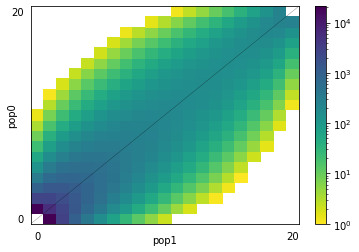

In [30]:
popt = y_test1[1975]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/true1.jpeg', dpi=300)

In [ ]:
print(y_test1[1975])

[6.28960298e+01 1.53831048e+01 7.05036631e+00 4.59788985e-01
 3.09343946e-02]


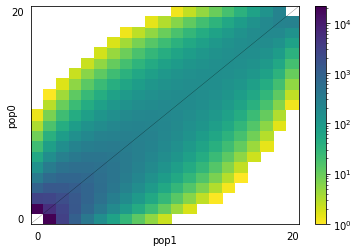

In [31]:
popt = y_pred1[1975]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/pred11.jpeg', dpi=300)

In [ ]:
print(y_pred1[1975])

[6.28530617e+01 1.56489892e+01 7.47511894e+00 3.48610842e-01
 3.16936124e-02]


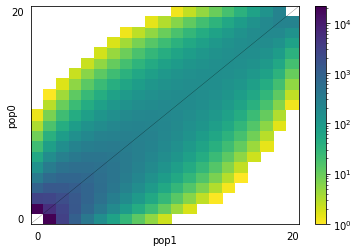

In [32]:
popt = y_pred3[1975]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/pred12.jpeg', dpi=300)

In [ ]:
print(y_pred3[1975])

[6.28530617e+01 1.63629541e+01 7.45202589e+00 3.75310971e-01
 3.15604909e-02]


#### For the Second model

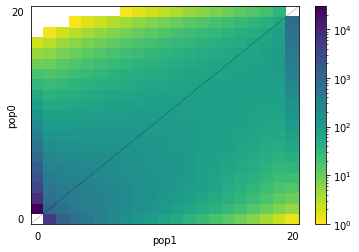

In [33]:
popt = y_test2[2345]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/true2.jpeg', dpi=300)

In [ ]:
print(y_test2[2345])

[6.1165045e+01 1.0000000e-01 5.0000000e+00 2.5000000e+00 5.0000000e-02]


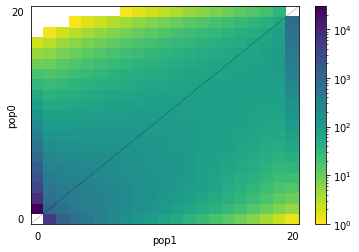

In [34]:
popt = y_pred2[2345]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/pred21.jpeg', dpi=300)

In [ ]:
print(y_pred2[2345])

[6.12329027e+01 1.00000000e-01 5.00000000e+00 2.49997009e+00
 5.00000013e-02]


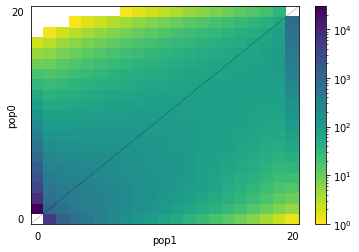

In [35]:
popt = y_pred4[2345]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
model = func_ex(popt, ns, pts_l)
data = model * theta
pylab.figure(i)
dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
pylab.savefig(f'/content/pred22.jpeg', dpi=300)

In [ ]:
print(y_pred4[2345])

[6.12329027e+01 1.00000000e-01 5.00000000e+00 2.49997009e+00
 5.00000013e-02]


### Download models

In [11]:
filename1 = '/content/drive/MyDrive/ML_DI/MultiOutputRegressor1.sav'
MultiOutputRegressor1 = pickle.load(open(filename1, 'rb'))
filename2 = '/content/drive/MyDrive/ML_DI/MultiOutputRegressor2.sav'
MultiOutputRegressor2 = pickle.load(open(filename2, 'rb'))
filename3 = '/content/drive/MyDrive/ML_DI/RegressorChain1.sav'
RegressorChain1 = pickle.load(open(filename3, 'rb'))
filename4 = '/content/drive/MyDrive/ML_DI/RegressorChain2.sav'
RegressorChain2 = pickle.load(open(filename4, 'rb'))

In [12]:
y_pred1 = MultiOutputRegressor1.predict(X_test1)
y_pred2 = MultiOutputRegressor2.predict(X_test2)
y_pred3 = RegressorChain1.predict(X_test1)
y_pred4 = RegressorChain2.predict(X_test2)

### Random search Metric

##### Random search parameters

In [17]:
N = 1000 # number of random points
M = 100 # size of test sample

##### Random search

In [ ]:
ll = []
NN = []
y_test_for_metrics = y_test2[:M]
func_ex = dadi.Numerics.make_extrap_log_func(model_func)
eps = 0.5

for y in tqdm(y_test_for_metrics):
    idx = np.where(y_test_for_metrics == y)
    data = func_ex(y, ns, pts_l) * theta
    model = func_ex(y_pred4[idx[0][0]], ns, pts_l)
    ll_model = dadi.Inference.ll_multinom(model, data)
    ll_model_random = 0
    i = 0
    while abs(ll_model - ll_model_random) > eps:
        i += 1
        y_random = np.array([sts.uniform.rvs(loc = lower_bound[0], scale = upper_bound[0] + lower_bound[0]),
                            sts.uniform.rvs(loc = lower_bound[1], scale = upper_bound[1] + lower_bound[1]),
                            sts.uniform.rvs(loc = lower_bound[2], scale = upper_bound[2] + lower_bound[2]),
                            sts.uniform.rvs(loc = lower_bound[3], scale = upper_bound[3] + lower_bound[3]),
                            sts.uniform.rvs(loc = 0.001, scale = 0.101)]).T
        model_random = func_ex(y_random, ns, pts_l)
        ll_model_random = dadi.Inference.ll_multinom(model_random, data)
        nn = i
    NN.append(nn)
    ll.append(ll_model_random)

##### Random search results

In [ ]:
NN_1 = np.array(NN)
NN_mean1 = np.mean(NN_1)
NN_mean1

1172.36

In [ ]:
NN_2 = np.array(NN)
NN_mean2 = np.mean(NN_2)
NN_mean2

854.4722222222222

In [21]:
NN_3 = np.array(NN)
NN_mean3 = np.mean(NN_3)
NN_mean3

1034.433

In [23]:
NN_4 = np.array(NN)
NN_mean4 = np.mean(NN_4)
NN_mean4

925.21